In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

#### IMPORTING MODULES

In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

2023-01-24 16:10:49.294647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 16:10:49.680381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 16:10:49.680400: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-24 16:10:49.731016: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-24 16:10:50.868800: W tensorflow/stream_executor/platform/de

#### EXTRACTING DATA

In [3]:
def extract_data(filename,numImages):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28*28*numImages)
        data = np.frombuffer(buf,dtype=np.uint8).astype(np.float32)
        data = data.reshape(numImages*28*28)
        return data

In [4]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)
train_data = train_data.reshape(-1,28,28,1)
test_data = test_data.reshape(-1,28,28,1)
train_data.shape,test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

#### Rescaling

In [5]:
train_data = train_data/np.max(train_data)
test_data = test_data/np.max(test_data)

#### Dividing the training data into 4:1 ratio for training the model

In [6]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,train_data,test_size=0.2,train_size=0.8,random_state=13)
train_X.shape,valid_X.shape,train_ground.shape,valid_ground.shape

((48000, 28, 28, 1),
 (12000, 28, 28, 1),
 (48000, 28, 28, 1),
 (12000, 28, 28, 1))

#### Initializing Hyperparameters

In [7]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

#### The autoencoder architecture

In [8]:
def autoencoder(input_img):
    #encode
    conv1 = Conv2D(32,(3,3),padding = 'same',activation = 'relu')(input_img)
    downs1 = MaxPooling2D(pool_size=(2,2))(conv1)
    conv2 = Conv2D(64,(3,3),padding = 'same',activation = 'relu')(downs1)
    downs2 = MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = Conv2D(128,(3,3),padding='same',activation = 'relu')(downs2)

    #decode
    conv4 = Conv2D(128,(3,3),padding = 'same',activation = 'relu')(conv3)
    downs3 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64,(3,3),padding = 'same',activation = 'relu')(downs3)
    downs4 = UpSampling2D((2,2))(conv5)
    conv6 = Conv2D(32,(3,3),padding='same',activation = 'relu')(downs4)
    conv7 = Conv2D(1,(3,3),padding='same',activation = 'sigmoid')(conv6)

    return conv7


In [9]:
autoencoder = Model(input_img,autoencoder(input_img))
autoencoder.compile(loss = 'mean_squared_error',optimizer = RMSprop())

2023-01-24 16:10:55.184171: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-24 16:10:55.184238: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nishant-OMEN-Laptop-15-ek0xxx): /proc/driver/nvidia/version does not exist
2023-01-24 16:10:55.185445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856 

#### Training the Data

In [11]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground)) 

Epoch 1/50
375/375 [==============================] - 130s 346ms/step - loss: 0.0349 - val_loss: 0.0125
Epoch 2/50
375/375 [==============================] - 133s 354ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 3/50
375/375 [==============================] - 134s 358ms/step - loss: 0.0068 - val_loss: 0.0050
Epoch 4/50
375/375 [==============================] - 136s 363ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/50
375/375 [==============================] - 122s 326ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 6/50
375/375 [==============================] - 122s 325ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 7/50
375/375 [==============================] - 127s 338ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/50
375/375 [==============================] - 133s 354ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 9/50
375/375 [==============================] - 133s 355ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 10/50
375/375 [==============================] - 132s 353m

In [12]:
pred = autoencoder.predict(test_data)
pred.shape

313/313 [==============================] - 5s 15ms/step


(10000, 28, 28, 1)

In [13]:
autoencoder.save('test.h5')

In [17]:
autoencoder2 = keras.models.load_model('./test.h5') 
pred = autoencoder2.predict(test_data)

    

313/313 [==============================] - 5s 16ms/step


2

Test Images
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


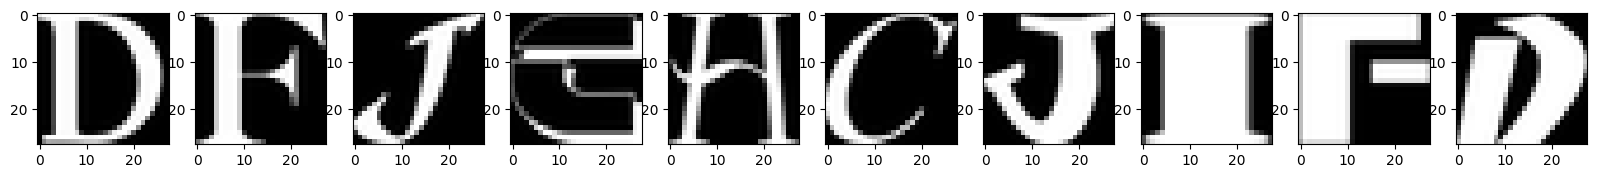

Reconstruction of Test Images


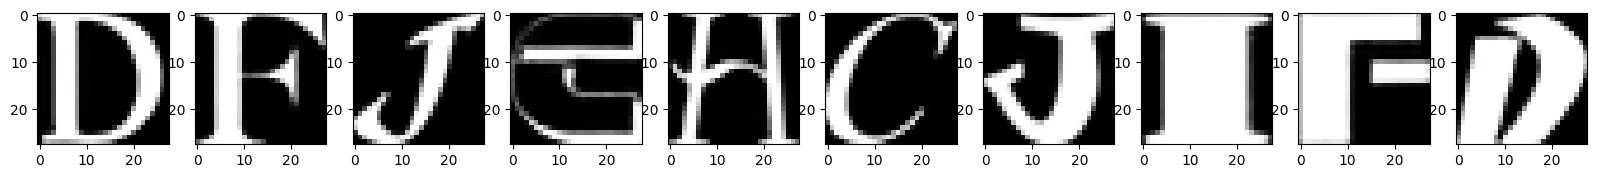

In [15]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    print(test_data.shape)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    # curr_lbl = test_labels[i]
    # plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [16]:
a = np.array([[[3,2],[1,2]],[[3,2],[1,2]]])
a[...,0]

array([[3, 1],
       [3, 1]])